# Data Management Plan

## Predicting genre and popularity of songs using  Spotify API

##  Ali Afsharian

This project analyses some datasets from Spotify and we want to use different attributes to predict the genre of the music and find the relations between these attributes to see if the song is going to be popular.
<br><br>First we are going to creat a database in MySQL and a table to put our data into it.
<br>The tracks_all table contains 18 columns for track features. Columns involve different information from artist's name, album's name, popularity and genre to audio features. 

```mysql
CREATE DATABASE spotify;

USE spotify;

CREATE TABLE tracks_all (
	artist VARCHAR (255),
    album VARCHAR (255),
    track_name VARCHAR (255),
    track_id VARCHAR (255),
    popularity INT,
    genre VARCHAR (255),
    danceability FLOAT,
	energy FLOAT,
    key_ INT,
    loudness FLOAT,
    mode_ INT,
    speechiness FLOAT,
    instrumentalness FLOAT,
    liveness FLOAT,
    valence FLOAT,
    tempo FLOAT,
    duration_ms INT,
    time_signature INT
    );
    
```

Now, we are going to define a function in python to retrive track information from Spotify API and put them into MySQL table which is created before.
<br> From our developer dashboard page, we retrieve Client ID and Client Secret which are required to make connection with Spotify API in Python. 
<br>***Note:*** Spotify allows to get maximum 100 results per query which is why a for loop is utilized.

In [1]:
# Reading a text file contains credentials
with open('credentials.txt') as file:
    lines = [line.rstrip() for line in file]

username = lines[0]
password = lines[1]

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import mysql.connector

# Authorization to access Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=username,
                                                           client_secret=password))



# Define a function to extract data from particular playlist by giving creator and playlist ID
def call_playlist(creator, playlist_id,genre):
    
    # Make a connection with MySQL
    cnx = mysql.connector.connect(user='root', password='0000',host='127.0.0.1', database='spotify')
    
    # Create a list which contains all variables' name
    playlist_features_list = ["artist","album","track_name", "track_id","popularity","genre","acousticness","danceability",
                              "energy","key","loudness","mode", "speechiness","instrumentalness",
                              "liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    
    for i in range(0,300,100):
        # Search in given playlist to retrive tracks' data
        playlist = sp.user_playlist_tracks(creator, playlist_id, limit = 100, offset = i)["items"]
        
        for track in playlist:

            playlist_features = {}
            
            # Get metadata
            playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
            playlist_features["album"] = track["track"]["album"]["name"]
            playlist_features["track_name"] = track["track"]["name"]
            playlist_features["track_id"] = track["track"]["id"]
            playlist_features["popularity"] = track["track"]["popularity"]
            playlist_features["genre"] = genre
            
                    
            # Get audio features
            audio_features = sp.audio_features(playlist_features["track_id"])[0]
            for feature in playlist_features_list[6:]:
                playlist_features[feature] = audio_features[feature]
            
            # Move data into MySQL database
            placeholders = ', '.join(['%s'] * len(playlist_features))                
            mysql_insert_query = "INSERT INTO tracks_all VALUES (%s)" %placeholders
            cursor = cnx.cursor()
            cursor.execute(mysql_insert_query,list(playlist_features.values()))
            cnx.commit()

        
            # Concat the dfs
            track_df = pd.DataFrame(playlist_features, index = [0])
            playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

        #Step 3
    cnx.close()
    return playlist_df.head ()


Here we call the function to get data from different playlists.
<br>Playlists names: Rock Classic -  Rap Hits (2010-2021) - Jazz Classic - 2000s Country

In [3]:
call_playlist("spotify:user:1145955352","spotify:playlist:4riovLwMCrY3q0Cd4e0Sqp","rap")

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Chief Keef,Finally Rich,Love Sosa,01Lr5YepbgjXAWR9iOEyH1,72,rap,0.03610,0.772,0.413,0,-8.193,0,0.0890,0,0.111,0.211,131.965,246213,4
1,Travis Scott,Birds In The Trap Sing McKnight,goosebumps,6gBFPUFcJLzWGx4lenP6h2,87,rap,0.08470,0.841,0.728,7,-3.370,1,0.0484,0,0.149,0.430,130.049,243837,4
2,Lil Uzi Vert,Luv Is Rage 2,XO Tour Llif3,7GX5flRQZVHRAGd6B4TmDO,85,rap,0.00264,0.732,0.750,11,-6.366,0,0.2310,0,0.109,0.401,155.096,182707,4
3,Playboi Carti,Playboi Carti,Magnolia,1e1JKLEDKP7hEQzJfNAgPl,81,rap,0.01140,0.791,0.582,11,-7.323,0,0.2860,0,0.350,0.443,162.991,181812,4
4,XXXTENTACION,?,Hope,2ZRo7axmMPeSVUvDbGkJah,87,rap,0.66100,0.592,0.457,9,-6.081,0,0.0603,0.000331,0.146,0.225,146.040,110886,4


In [4]:
call_playlist("spotify:user:1145955352","spotify:playlist:37i9dQZF1DXbITWG1ZJKYt","jazz")

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Billie Holiday,Solitude,Blue Moon,1pZn8AX1WulW8IO338hE5D,66,jazz,0.982,0.639,0.2690,8,-11.435,1,0.0698,0.120000,0.141,0.539,124.866,207827,4
1,Chet Baker,Chet Baker Sings: It Could Happen To You [Orig...,Everything Happens to Me,4Y5fyQ5fBysC32Na5sZT3J,56,jazz,0.809,0.511,0.1930,7,-15.148,1,0.0439,0.000022,0.129,0.164,116.348,305187,4
2,Bill Evans Trio,Waltz For Debby [Original Jazz Classics Remast...,My Foolish Heart,6yKkA8HzwWTZ5taIMaG4Nm,64,jazz,0.935,0.395,0.1210,9,-23.427,1,0.0327,0.397000,0.697,0.139,114.521,297320,4
3,John Coltrane,The Gentle Side Of John Coltrane,My One And Only Love,1BPmVDqR4cX9aFC0Qx0eWn,57,jazz,0.988,0.461,0.0546,0,-18.982,1,0.0362,0.208000,0.126,0.230,128.910,296667,4
4,Chick Corea,The Best Of Chick Corea,Windows,0m8tSPLHhjhGToD6LW0RPp,53,jazz,0.673,0.503,0.3440,1,-19.024,1,0.0369,0.381000,0.096,0.468,108.489,191933,4


In [5]:
call_playlist("spotify:user:1145955352","spotify:playlist:37i9dQZF1DXdxUH6sNtcDe","country")

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Brooks & Dunn,Red Dirt Road,Red Dirt Road,3EZzghqykkfOB0Z8d0kTSt,68,country,0.0664,0.555,0.868,5,-3.798,1,0.0403,0.000117,0.116,0.479,136.120,260360,4
1,Travis Tritt,Down The Road I Go,It's A Great Day To Be Alive,3oW6SWwGqiZSPTiAp7ZQoH,72,country,0.2460,0.595,0.653,7,-4.935,1,0.0265,0.000000,0.264,0.542,128.930,241533,4
2,Carrie Underwood,Some Hearts,Before He Cheats,0ZUo4YjG4saFnEJhdWp9Bt,77,country,0.2710,0.519,0.749,6,-3.318,0,0.0405,0.000000,0.119,0.290,147.905,199947,4
3,Sara Evans,Restless,Suds in the Bucket,6NhpIdjYoufuNNlBsgOztc,68,country,0.0520,0.511,0.903,10,-3.163,1,0.0397,0.000529,0.304,0.898,161.992,227267,4
4,Keith Urban,Golden Road,Somebody Like You,0b9djfiuDIMw1zKH6gV74g,68,country,0.1080,0.624,0.840,4,-5.768,1,0.0337,0.000546,0.144,0.656,111.020,323040,4


In the following, we get the data from MySQL database and make dataframe to collect data with Pandas.

In [6]:
cnx = mysql.connector.connect(user='root', password='0000',host='127.0.0.1', database='spotify')

# Extract data from MySQL database and collect in a table
cursor = cnx.cursor()
cursor.execute('SELECT * FROM tracks_all')
table_tracks = cursor.fetchall()

# Create dataframe
df_spotify = pd.DataFrame(table_tracks)
cnx.close()

df_spotify.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,AC/DC,Highway to Hell,Highway to Hell,2zYzyRzz6pRmhPzyfMEC8s,85,rock,0.0610,0.574,0.913,6,-4.793,0,0.1330,0.001580,0.156,0.423,115.728,208400,4
1,Guns N' Roses,Appetite For Destruction,Paradise City,3YBZIN3rekqsKxbJc9FZko,80,rock,0.0169,0.273,0.952,11,-8.762,1,0.0843,0.011100,0.142,0.472,100.271,405640,4
2,Queen,The Game (Deluxe Remastered Version),Another One Bites The Dust - Remastered 2011,57JVGBtBLCfHw2muk5416J,75,rock,0.1120,0.933,0.528,5,-6.472,0,0.1620,0.329000,0.163,0.756,109.975,214653,4
3,Led Zeppelin,Led Zeppelin IV (Deluxe Edition),Black Dog - Remaster,3qT4bUD1MaWpGrTwcvguhb,76,rock,0.3960,0.437,0.864,4,-7.842,0,0.0904,0.031400,0.242,0.749,81.394,295387,4
4,Aerosmith,Aerosmith,Dream On,5MxNLUsfh7uzROypsoO5qe,81,rock,0.3880,0.307,0.433,1,-10.057,1,0.0290,0.000091,0.332,0.224,160.900,266960,4


- We can see that the columns has not right names, and we correct the columns name in the following.

In [9]:
df_spotify.columns = ["artist","album","track_name", "track_id","popularity","genre","acousticness","danceability",
                              "energy","key","loudness","mode", "speechiness","instrumentalness",
                              "liveness","valence","tempo", "duration","time_signature"]
df_spotify.head()

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration,time_signature
0,AC/DC,Highway to Hell,Highway to Hell,2zYzyRzz6pRmhPzyfMEC8s,85,rock,0.0610,0.574,0.913,6,-4.793,0,0.1330,0.001580,0.156,0.423,115.728,208400,4
1,Guns N' Roses,Appetite For Destruction,Paradise City,3YBZIN3rekqsKxbJc9FZko,80,rock,0.0169,0.273,0.952,11,-8.762,1,0.0843,0.011100,0.142,0.472,100.271,405640,4
2,Queen,The Game (Deluxe Remastered Version),Another One Bites The Dust - Remastered 2011,57JVGBtBLCfHw2muk5416J,75,rock,0.1120,0.933,0.528,5,-6.472,0,0.1620,0.329000,0.163,0.756,109.975,214653,4
3,Led Zeppelin,Led Zeppelin IV (Deluxe Edition),Black Dog - Remaster,3qT4bUD1MaWpGrTwcvguhb,76,rock,0.3960,0.437,0.864,4,-7.842,0,0.0904,0.031400,0.242,0.749,81.394,295387,4
4,Aerosmith,Aerosmith,Dream On,5MxNLUsfh7uzROypsoO5qe,81,rock,0.3880,0.307,0.433,1,-10.057,1,0.0290,0.000091,0.332,0.224,160.900,266960,4


- Here, we check if there is any missing values in the colmns.

In [10]:
df_spotify[df_spotify.isnull().any(axis=1)]

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration,time_signature


- Also, 'duration' feature is being expresseed in milliseconds which makes little sense in the contex of song duration, so we convert it to minutes.   

In [11]:
df_spotify['duration']=round(df_spotify['duration']/60000,2)

In [12]:
df_spotify.head()

,artist,album,track_name,track_id,popularity,genre,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration,time_signature
0,AC/DC,Highway to Hell,Highway to Hell,2zYzyRzz6pRmhPzyfMEC8s,85,rock,0.0610,0.574,0.913,6,-4.793,0,0.1330,0.001580,0.156,0.423,115.728,3.47,4
1,Guns N' Roses,Appetite For Destruction,Paradise City,3YBZIN3rekqsKxbJc9FZko,80,rock,0.0169,0.273,0.952,11,-8.762,1,0.0843,0.011100,0.142,0.472,100.271,6.76,4
2,Queen,The Game (Deluxe Remastered Version),Another One Bites The Dust - Remastered 2011,57JVGBtBLCfHw2muk5416J,75,rock,0.1120,0.933,0.528,5,-6.472,0,0.1620,0.329000,0.163,0.756,109.975,3.58,4
3,Led Zeppelin,Led Zeppelin IV (Deluxe Edition),Black Dog - Remaster,3qT4bUD1MaWpGrTwcvguhb,76,rock,0.3960,0.437,0.864,4,-7.842,0,0.0904,0.031400,0.242,0.749,81.394,4.92,4
4,Aerosmith,Aerosmith,Dream On,5MxNLUsfh7uzROypsoO5qe,81,rock,0.3880,0.307,0.433,1,-10.057,1,0.0290,0.000091,0.332,0.224,160.900,4.45,4


## Features Correlation

Let's look at the heatmap to make a better sense about correlation between features.

<AxesSubplot:>

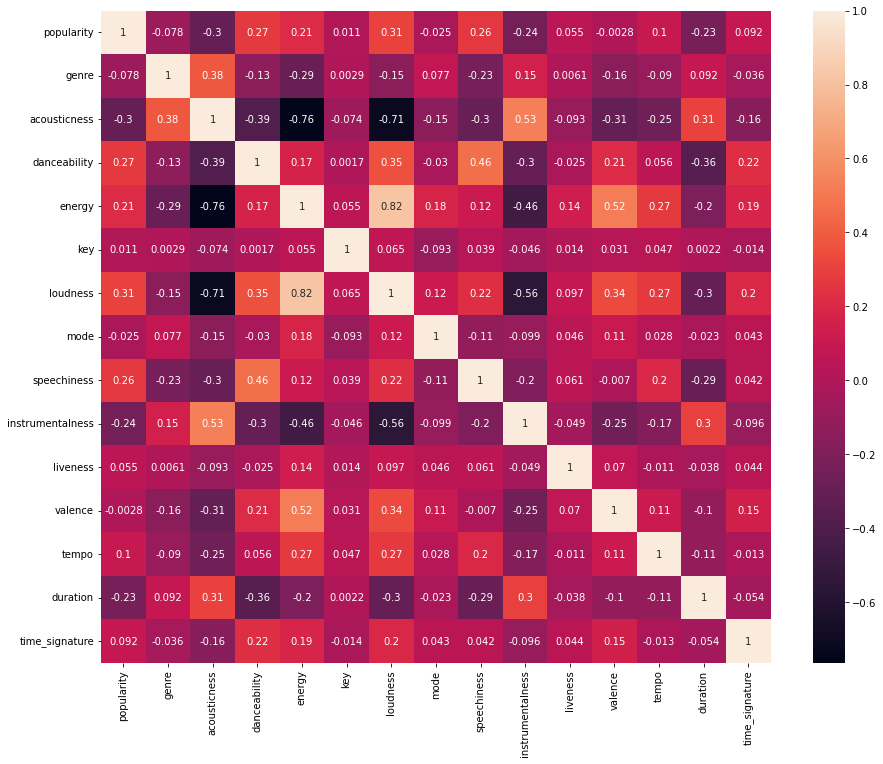

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding 'genre' featre
cleanup_nums = {"genre":{"rock": 1, "rap": 2, "jazz":3, "country":4}}
df_spotify_genre = df_spotify.replace(cleanup_nums)

plt.figure(figsize = (15,12))
# Plot heatmap between all remaining features
sns.heatmap(df_spotify_genre.corr(),annot = True)

From the heatmap, we see that ‘energy’ and ‘loudness’ have the highest correlation, and a positive one, which does not surprise. Also, ‘energy’ and ‘acousticness’ have a highly-correlated inverse relationship. It is almost obvious, te more a song skews towards being acoustic, the less energy it tends to be.
<br>By looking at 'popularity' as dependant variable, we notice very poor correlation values across our independent variables. The best we get is a -0.3 between ‘acousticness’ and ‘popularity’.

Text(0, 0.5, 'avg. Popularity')

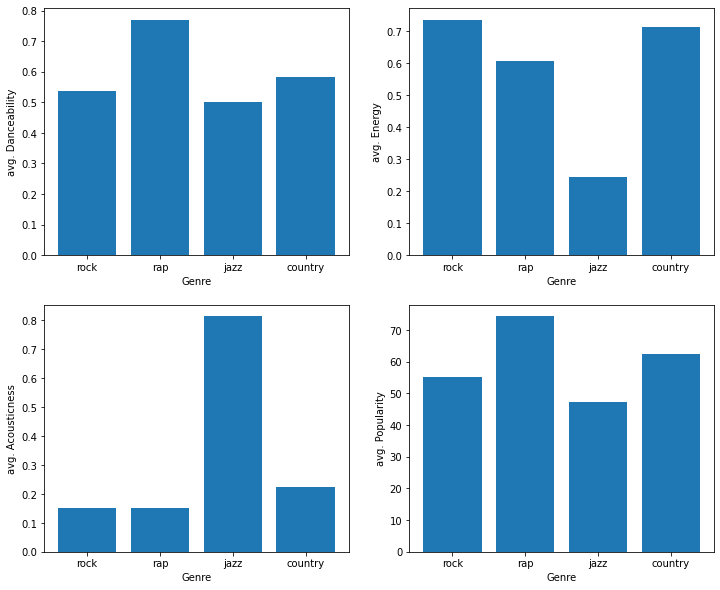

In [96]:
import matplotlib.pyplot as plt

genres = ['rock','rap','jazz','country']

means_dance = df_spotify_genre.groupby('genre')['danceability'].mean()
means_energy = df_spotify_genre.groupby('genre')['energy'].mean()
means_popularity = df_spotify_genre.groupby('genre')['popularity'].mean()
means_acousticness = df_spotify_genre.groupby('genre')['acousticness'].mean()

fig, axs = plt.subplots(2, 2,figsize=(12,10))

axs[0, 0].bar(genres,means_dance)
axs[0, 0].set_xlabel('Genre')
axs[0, 0].set_ylabel('avg. Danceability')

axs[0, 1].bar(genres,means_energy)
axs[0, 1].set_xlabel('Genre')
axs[0, 1].set_ylabel('avg. Energy')

axs[1, 0].bar(genres,means_acousticness)
axs[1, 0].set_xlabel('Genre')
axs[1, 0].set_ylabel('avg. Acousticness')

axs[1, 1].bar(genres,means_popularity)
axs[1, 1].set_xlabel('Genre')
axs[1, 1].set_ylabel('avg. Popularity')

We can see that the highest 'danceability' belongs to the 'rap' genre which has higher tempo. But musics with 'rock' and 'country' genre have higher 'energy' attribute in average.
<br>Also, as we expected, the accousticness of musics in 'jazz' are much greater than others.
<br>From the last graph, we found that 'rap' musics have more popular in average in comparison with three other genres.

## Genre - Classification 

In [21]:
from sklearn.model_selection import train_test_split

# Separate predictor and target features
df_spotify_predictor = df_spotify.drop(['artist','album','track_name',
                                        'track_id','popularity','genre'],
                                       axis='columns')
target = df_spotify['genre']

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split (df_spotify_predictor,target,test_size=0.3, random_state=3)

### 1. Random Forest Classification

Model Accuracy = % 87.61


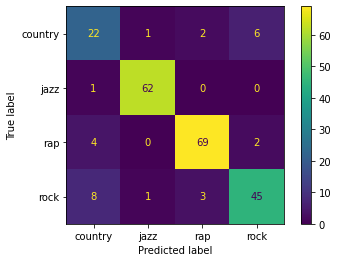

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# Train random forest model on train data
cls_rf = RandomForestClassifier(n_estimators=30)
cls_rf.fit (x_train,y_train)#,y_train.values.ravel())

# Plot confusion matrix 
y_predicted = cls_rf.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')#,
                      #display_labels=["rock","rap","jazz","country"])

# Calculate model accuracy
print ('Model Accuracy = %', 
       round(cls_rf.score(x_test,y_test)*100,2))

From the results, we can see that the RandomForest classification shows great performance in classifying tracks based on their genres.

### 2. SVM Classification

Model Accuracy = % 50.0


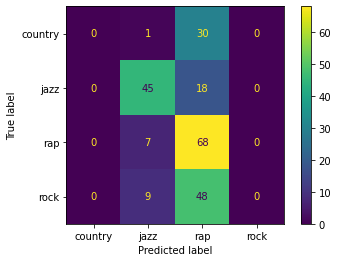

In [23]:
from sklearn.svm import SVC

# Train SVM model on train data
cls_svm = SVC(random_state=42)
cls_svm.fit(x_train,y_train)

# Plot confusion matrix 
y_predicted = cls_svm.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', 
       round(cls_svm.score(x_test,y_test)*100,2))

We can see that primary SVM model has low accuracy.
Now we want to optimize parameters in order to improve model accuracy. 

In [24]:
from sklearn.model_selection import GridSearchCV

# Set different parameters to ckeck
param_grid = [
    {'C':[0.5,1,10,100],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},
]

# Find ideal parameters
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose = 0
)

optimal_params.fit(x_train,y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


We see that the ideal value for C is 100 and for gamma is 0.001.
Now we train our model with these ideal values.

Model Accuracy = % 74.34


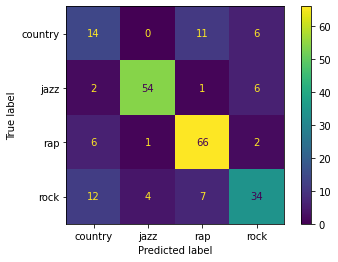

In [25]:
cls_svm = SVC(random_state=42,C=100,gamma=0.001)
cls_svm.fit(x_train,y_train)

# Plot confusion matrix 
y_predicted = cls_svm.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', round(cls_svm.score(x_test,y_test)*100,2))

With optimal parameters, the accuracy improve significantly.
<br>But yet RandomForest classifiation method has better perfromance.

## Popularity - Regression

In this section, we are going to predict tracks' popularity with different methods.
<br>First, we will try linear regression model and evaluate the results. And then try to implement the other methods.

- Check if there is any rows with 'popularity' = 0

In [26]:
#Number of rows with 'popularity' = 0
len(df_spotify[df_spotify['popularity']==0])

54

Since they are not too many, we are going to delete them from the table to robust our prediction

In [27]:
len (df_spotify)

751

In [28]:
# Delete rows with 'popularity' = 0 from the dataset
df_spotify_clean = df_spotify.drop(df_spotify[df_spotify['popularity']==0].index, axis= 'index')

In [29]:
len (df_spotify_clean)

697

- Now let's split the training and test data and build our regression models on training data.

In [32]:
# Separate predictor and target features
df_spotify_predictor = df_spotify_clean.drop(['artist','album','track_name',
                                        'track_id','popularity','genre'],
                                       axis='columns')
target = df_spotify_clean['popularity']

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split (df_spotify_predictor,target,test_size=0.3,random_state=3)

### 1. Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Build Linear Regression model on training data
reg_linear = LinearRegression()
reg_linear.fit(x_train,y_train)

# Calculate R-squared value
print ('R-squared = ', round (reg_linear.score(x_test,y_test),4))

# Calculate RMSE , MSE
y_predicted = reg_linear.predict (x_test)
print('MSE = ', round (mean_squared_error(y_test, y_predicted),2))
print('RMSE = ', round (np.sqrt(mean_squared_error(y_test, y_predicted)),2))

R-squared =  0.2768
MSE =  154.12
RMSE =  12.41


The result show that the R-suared value is too small which means the linear regression model weakly explain the variance of the target value ('popularity').
<br>Also, having MSE = 154.12 for the residuals is huge for a range of 0–100 in ‘popularity’.

### 2. Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(max_depth=2, random_state=3)
reg_rf.fit(x_train,y_train)

# Calculate R-squared value
print ('R-squared = ', round (reg_rf.score(x_test,y_test),4))

# Calculate RMSE , MSE
y_predicted = reg_rf.predict (x_test)
print('MSE = ', round (mean_squared_error(y_test, y_predicted),2))
print('RMSE = ', round (np.sqrt(mean_squared_error(y_test, y_predicted)),2))

R-squared =  0.1995
MSE =  170.6
RMSE =  13.06


We can see that the primary RandomForest model performance is less accurate thn linear regression model.
<br>In the following, we check SVM regressor and try to optimize its performance.

### 3. SVM Regressor

In [66]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

reg_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg_svr.fit(x_train,y_train)

# Calculate R-squared value
print ('R-squared = ', round (reg_svr.score(x_test,y_test),4))

# Calculate RMSE , MSE
y_predicted = reg_svr.predict (x_test)
print('MSE = ', round (mean_squared_error(y_test, y_predicted),2))
print('RMSE = ', round (np.sqrt(mean_squared_error(y_test, y_predicted)),2))

R-squared =  0.3034
MSE =  148.46
RMSE =  12.18


- Due to the weak results, we are going to optimize the model by tuning hyperparameters and check the model performance woth ideal values.

In [67]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [69]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200]},
                   random_state=42, verbose=2)

In [70]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [71]:
# Calculate R-squared value
print ('R-squared = ', round (rf_random.score(x_test,y_test),4))

# Calculate RMSE , MSE
y_predicted = rf_random.predict (x_test)
print('MSE = ', round (mean_squared_error(y_test, y_predicted),2))
print('RMSE = ', round (np.sqrt(mean_squared_error(y_test, y_predicted)),2))

R-squared =  0.2504
MSE =  159.74
RMSE =  12.64


In [72]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [73]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [74]:
# Calculate R-squared value
print ('R-squared = ', round (grid_search.score(x_test,y_test),4))

# Calculate RMSE , MSE
y_predicted = grid_search.predict (x_test)
print('MSE = ', round (mean_squared_error(y_test, y_predicted),2))
print('RMSE = ', round (np.sqrt(mean_squared_error(y_test, y_predicted)),2))

R-squared =  0.2563
MSE =  158.49
RMSE =  12.59


We can see that with all these optimization, we could not reach to an improvement in our prediction.
<br>Since he results we are getting with our regression methods are not satisfying.
<br>Now we are going to try classification methods in order to predict the popularity.
<br>At the fisrt step, we divide our the popularity feature into 3 different group ('Low', 'Medium', 'High).
<br>Then we will try to predict by classification methods and check the accuracy.

## Popularity - Classification

In order to set up classification models, we need to convert the continuous integer values of popularity into categorical variables.
<br>We will segment our popularity values into equal bins of ‘Low’, ‘Medium’ and ‘High’ popularity.

In [76]:
df_spotify_clean['popularity']=pd.cut(df_spotify.popularity, bins=3, labels=['Low','Medium','High'])
df_spotify_clean['popularity'].value_counts()

High      408
Medium    268
Low        21
Name: popularity, dtype: int64

Now, we want to separate the predictors, and split the data into training and test data.

In [86]:
# Encoding 'genre' feature
cleanup_nums = {"genre":{"rock": 1, "rap": 2, "jazz":3, "country":4}}
df_spotify_clean = df_spotify_clean.replace(cleanup_nums)

# Separate predictor and target features
df_spotify_predictor = df_spotify_clean.drop(['artist','album','track_name',
                                        'track_id','popularity'],
                                       axis='columns')
target = df_spotify_clean['popularity']

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split (df_spotify_predictor,target,test_size=0.3,random_state = 3)

### 1. Random Forest Classification

Model Accuracy = % 85.71


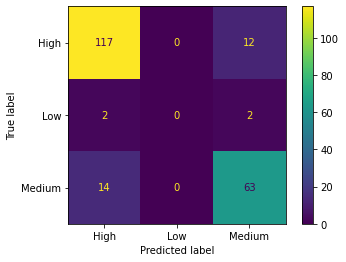

In [87]:
# Train random forest model on train data
cls_rf = RandomForestClassifier(n_estimators=30)
cls_rf.fit (x_train,y_train)

# Plot confusion matrix 
y_predicted = cls_rf.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', 
       round(cls_rf.score(x_test,y_test)*100,2))

We can see that random forest classification has about 85% accuracy in predicting popularity group.
<br>Now, let's test two additional models.

### 2. SVM Classsification

Model Accuracy = % 70.95


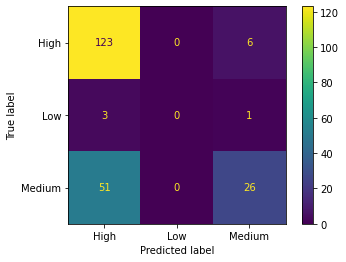

In [89]:
from sklearn.svm import SVC

# Train SVM model on train data
cls_svm = SVC(random_state=42)
cls_svm.fit(x_train,y_train)

# Plot confusion matrix 
y_predicted = cls_svm.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', 
       round(cls_svm.score(x_test,y_test)*100,2))

In [90]:
from sklearn.model_selection import GridSearchCV

# Set different parameters to ckeck
param_grid = [
    {'C':[0.5,1,10,100],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},
]

# Find ideal parameters
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose = 0
)

optimal_params.fit(x_train,y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Model Accuracy = % 82.38


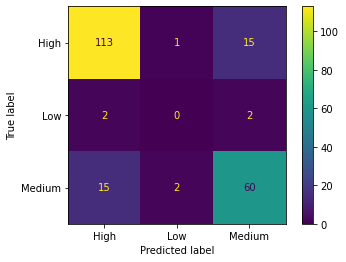

In [91]:
cls_svm = SVC(random_state=42,C=100,gamma=0.001)
cls_svm.fit(x_train,y_train)

# Plot confusion matrix 
y_predicted = cls_svm.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', round(cls_svm.score(x_test,y_test)*100,2))

We can reach to a accuracy 82% by optimizing support vector machine classification.

### 3. k-NN Classification

Model Accuracy = % 70.48


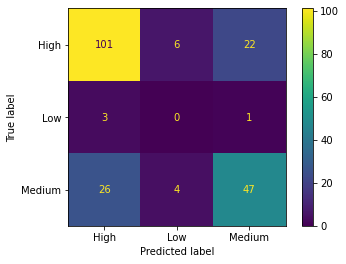

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
y_predicted = knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_predicted,
                      values_format='d')

# Calculate model accuracy
print ('Model Accuracy = %', round(knn.score(x_test,y_test)*100,2))

From the results, we can conclude that the random forest model shows the best performance in classification popularity feature which is divided in three groups ('Low', 'Medium', 'High). 

## Conclusion

The main purpose of our project was to see whether or not we would be able to accurately predict genres and popularity for some  of the popular playlists given from the Spotify API. 
<br>During our data preparation, we used Python code to be able to access the Spotify API and then move the data into MySQL database. After this, we showed correlation between different features and ploted some bar chart in order to get better insight about our dataset.
<br>We then build two different algorithm to predict the genre of a song based on the audio features and could reach to an accuracy 87.61% by Random Forest model.
<br>Furthermore, we built three different models for predicting popularity features. We had difficulities with setting up proper model to predict the target feature accurately. Since the results were disappointing, we decided to change the target variable into categorical type and predict the popularity with three different labels. In this way, our model showed better performances and our best result was 85.71% in accuracy for Random Forest Regression model.